# Fitting an SIR epidemic model
Here we fit a stochastic epidemic model. The inputs are time and $R_0$ and the outputs are the number of infected.

In [1]:
%pylab inline
import sys
sys.path.append('../')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import importlib
import pydra
import seaborn as sns
import plot_utils as pu
import tensorflowjs as tfjs
importlib.reload(pydra)
importlib.reload(pu)
import tensorflow as tf
from tqdm import tqdm

//anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
tf.__version__

'1.7.0'

# Define SIR model function

In [4]:
def SIR(beta,gamma,N=1000,T=10):
    Is = np.zeros(T)
    Ss = np.zeros(T)
    Is[0] = 1
    Ss[0] = N-Is[0]
    ts = range(T)
    for t in ts[1:]:
        infections = np.random.poisson(beta*Is[t-1]*Ss[t-1]/N)
        recoveries = np.random.poisson(gamma*Is[t-1])
        Is[t] = max(Is[t-1] + infections - recoveries,0)
        Ss[t] = max(Ss[t-1] - infections,0)
    Fs = 100.*(N - Ss[-1])/float(N)
    return ts,Ss,Is,Fs

## Test SIR model

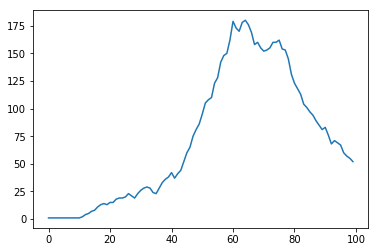

In [5]:
beta = 0.2
ts,_,Is,_ = SIR(beta,0.1,N=1000,T=100)
inputs = np.vstack((beta*np.ones(100),ts))
outputs = Is
plt.plot(ts,Is)

In [6]:
inputs = np.zeros(2,None)
outputs = np.zeros(None)

In [7]:
betas = np.random.uniform(high=1.0,low=0.0,size=3000)
inputs = None
outputs = None
for beta in betas:
    ts,_,Is,_ = SIR(beta,0.1,N=1000,T=100)
    Is[Is==0] = 1e-10 #if zero replace with small value.
    binput = np.vstack((beta*np.ones(100),ts))
    if inputs is None:
        inputs = binput.copy()
    else:
        inputs = np.hstack((binput,inputs))
    if outputs is None:
        outputs = Is
    else:
        outputs = np.hstack((Is,outputs))

In [8]:
print(inputs.shape)
print(outputs.shape)
outputs = np.atleast_2d(outputs)
print(outputs.shape)

(2, 300000)
(300000,)
(1, 300000)


# Instantiate Pydra model

In [9]:
model = pydra.Pydra(input_size=2,output_size=1,learning_rate=0.0005,output_distributions='Poisson',
                    cluster_size=10,activation='selu',dense_layer_size=128)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          384         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          16512       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          16512       dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [10]:
history = model.fit(inputs.T, outputs.T, batch_size=1000, epochs=30, verbose=1)

Epoch 1/30
300000/300000 [==============================] - 4s 12us/step - loss: 4.5167
Epoch 2/30
300000/300000 [==============================] - 3s 11us/step - loss: 3.9421
Epoch 3/30
300000/300000 [==============================] - 3s 11us/step - loss: 3.7581
Epoch 4/30
300000/300000 [==============================] - 3s 11us/step - loss: 3.5132
Epoch 5/30
300000/300000 [==============================] - 3s 11us/step - loss: 3.3697
Epoch 6/30
300000/300000 [==============================] - 4s 14us/step - loss: 3.3249
Epoch 7/30
300000/300000 [==============================] - 3s 11us/step - loss: 3.2114
Epoch 8/30
300000/300000 [==============================] - 3s 11us/step - loss: 3.1882
Epoch 9/30
300000/300000 [==============================] - 3s 11us/step - loss: 3.1242
Epoch 10/30
300000/300000 [==============================] - 4s 13us/step - loss: 3.1571
Epoch 11/30
300000/300000 [==============================] - 4s 12us/step - loss: 3.0833
Epoch 12/30
300000/300000 [===

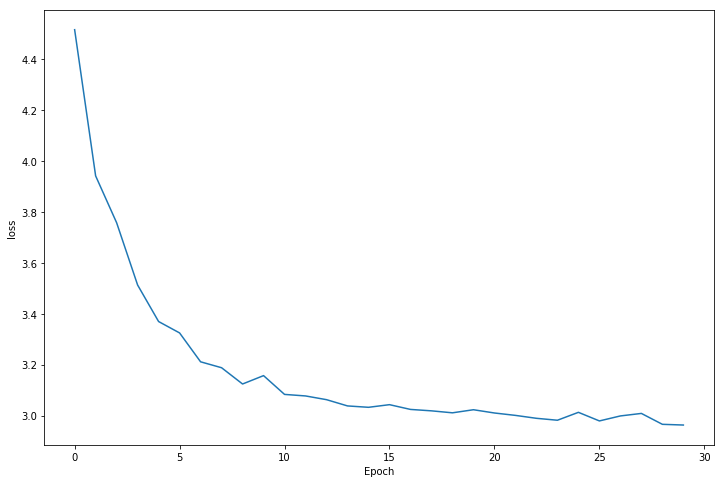

In [11]:
plt.figure(figsize=(12,8));
plt.plot(history.history['loss']); plt.xlabel('Epoch'); plt.ylabel('loss');

In [12]:
def plot_for_beta(beta):
    n = 1000
    t_test = np.float32(np.linspace(0.,100,num=n))

    x_test = np.vstack((beta*np.ones(n),t_test)).T

    output = model.generate_mdn_sample_from_ouput(x_test)
    plt.plot(t_test,output,'bo',alpha=0.5);

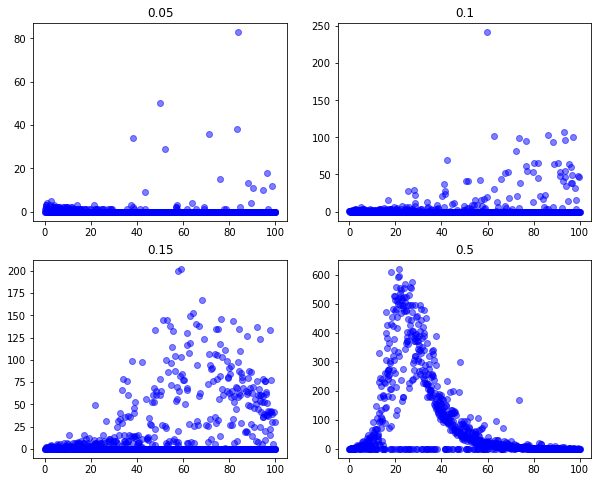

In [13]:
betas = [0.05,0.1,0.15,0.5]
plt.figure(figsize=(10,8));
for i,beta in enumerate(betas):
    plt.subplot(2,2,i+1);
    plot_for_beta(beta);
    plt.title(str(beta));

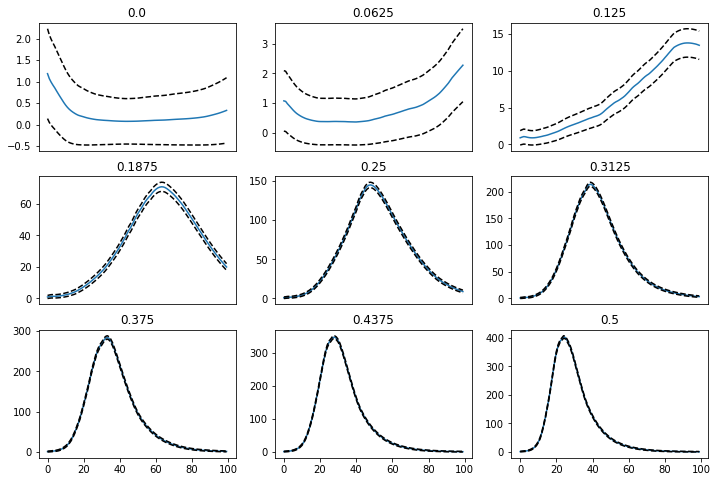

In [14]:
betas = np.linspace(0.,0.5,num=9)
plt.figure(figsize=(12,8));
n=100
for i,beta in enumerate(betas):
    plt.subplot(3,3,i+1);
    t_test = np.float32(np.linspace(0.0,100,num=n))
    x_test = np.vstack((beta*np.ones(n),t_test)).T
    output = model.predict(x_test)
    mu,sigma = pydra.get_stats(output,distribution='Poisson')
    plt.plot(mu)
    plt.plot(mu+np.sqrt(sigma),'k--');
    plt.plot(mu-np.sqrt(sigma),'k--');
    plt.title(str(beta));
    if i<6: plt.xticks([],[]);


# Perform KS-test

In [19]:
from scipy.stats import ks_2samp



def gen_comparison_sample(beta,t=100,n=100):
    
    t_test = np.float32(np.linspace(0.0,100,num=n))
    x_test = np.vstack((beta*np.ones(n),t_test)).T
    output = model.predict(x_test)
    y_test = pydra.generate_mdn_sample_from_ouput(output, output.size,distribution='Poisson')
    ts,_,y_original,_ = SIR(beta,0.1,N=1000,T=100)
    return y_original, y_test


def compare_ks(y_test,y_original):
    res = ks_2samp(y_test,y_original)
    return res.statistic

def ks_test_over_linspace(beta,n=100,sample_size=50):
    ksvals = np.zeros(n)
    Ytest = np.zeros((n,sample_size))
    Yoriginal = np.zeros((n,sample_size))
    for i in range(sample_size):
        y_original,y_test = gen_comparison_sample(beta,t=100,n=100)
        Ytest[:,i] = y_test
        Yoriginal[:,i] = y_original
    for i in range(ksvals.size):
        ksvals[i] = compare_ks(Ytest[i,:].flatten(),Yoriginal[i,:].flatten())
    xinput = np.linspace(0.,100.,num=n)
    return xinput,ksvals

xinput,pvals = ks_test_over_linspace(0.25)

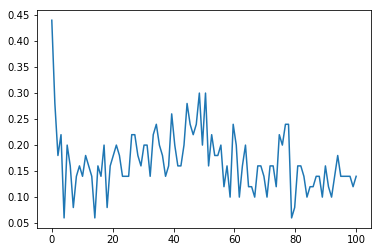

In [20]:
plt.plot(xinput,pvals)

In [21]:
def ks_evaluation_plot_statistics(beta):
    reps = 100
    n=100
    Xinput = np.zeros((reps,n))
    Pval = np.zeros((reps,n))
    for i in tqdm(range(reps)):

        xinput,pvals = ks_test_over_linspace(beta)
        Xinput[i,:] = xinput
        Pval[i,:] = pvals
    return Pval,xinput

In [22]:
Pval,xinput = ks_evaluation_plot_statistics(0.4)


  7%|▋         | 7/100 [00:04<00:52,  1.77it/s]Exception in thread Thread-5:
Traceback (most recent call last):
  File "//anaconda/envs/py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "//anaconda/envs/py36/lib/python3.6/site-packages/tqdm/_tqdm.py", line 103, in run
    for instance in self.tqdm_cls._instances:
  File "//anaconda/envs/py36/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 100/100 [00:54<00:00,  2.04it/s]


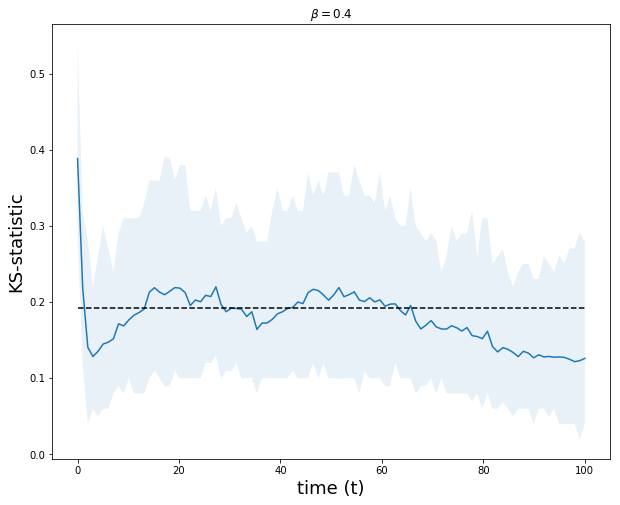

In [23]:
plt.figure(figsize=(10,8));
pmean = np.mean(Pval,axis=0)
lc,uc = np.percentile(Pval,[2.5,97.5],axis=0)
plt.plot(xinput,pmean);
plt.fill_between(xinput,lc,uc,alpha=0.1);
plt.xlabel('time (t)',fontsize=18);
plt.ylabel('KS-statistic',fontsize=18);
cval = np.sqrt(0.02)*1.36
plt.plot([0,100.],[cval,cval],'k--');
plt.title(r'$\beta=0.4$');
#plt.xlim(0.,5.);

In [89]:
Pval,xinput = ks_evaluation_plot_statistics(0.05)

100%|██████████| 100/100 [00:50<00:00,  1.57it/s]


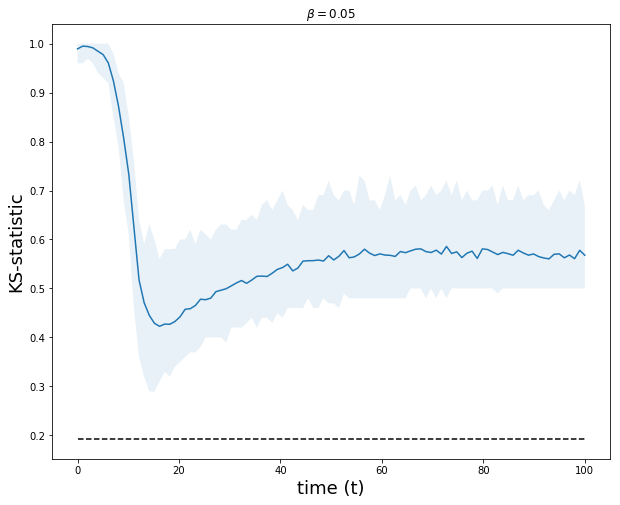

In [90]:
plt.figure(figsize=(10,8));
pmean = np.mean(Pval,axis=0)
lc,uc = np.percentile(Pval,[2.5,97.5],axis=0)
plt.plot(xinput,pmean);
plt.fill_between(xinput,lc,uc,alpha=0.1);
plt.xlabel('time (t)',fontsize=18);
plt.ylabel('KS-statistic',fontsize=18);
cval = np.sqrt(0.02)*1.36
plt.plot([0,100.],[cval,cval],'k--');
plt.title(r'$\beta=0.05$');

In [91]:
Pval,xinput = ks_evaluation_plot_statistics(0.25)

100%|██████████| 100/100 [01:18<00:00,  1.48it/s]


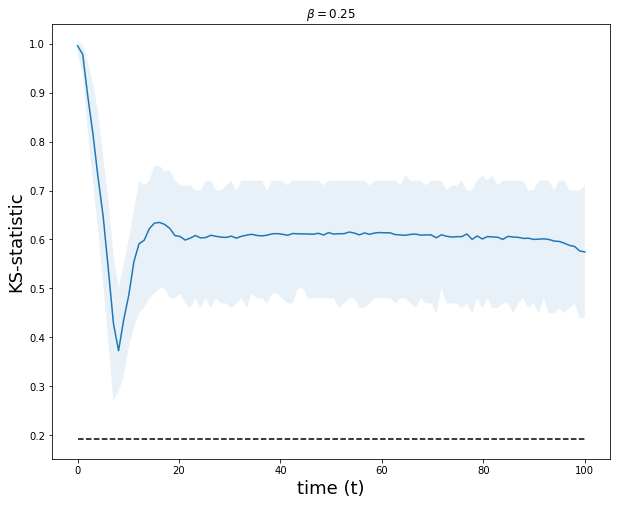

In [92]:
plt.figure(figsize=(10,8));
pmean = np.mean(Pval,axis=0)
lc,uc = np.percentile(Pval,[2.5,97.5],axis=0)
plt.plot(xinput,pmean);
plt.fill_between(xinput,lc,uc,alpha=0.1);
plt.xlabel('time (t)',fontsize=18);
plt.ylabel('KS-statistic',fontsize=18);
cval = np.sqrt(0.02)*1.36
plt.plot([0,100.],[cval,cval],'k--');
plt.title(r'$\beta=0.25$');

# Fit simpler model

## Create simple test model data

In [51]:
betas = np.random.uniform(high=1.0,low=0.0,size=1000)
inputs = None
outputs = None
for beta in betas:
    ts,_,Is,_ = SIR(beta,0.1,N=1000,T=100)
    binput = np.vstack((beta*np.ones(100),ts))
    
    output = model.predict(binput.T)
    mu,sigma = pydra.get_stats(output,distribution='Gamma')
    boutput = np.vstack((mu,sigma))
    if inputs is None:
        inputs = binput.copy()
    else:
        inputs = np.hstack((binput,inputs))
    
    if outputs is None:
        outputs = boutput.copy()
    else:
        outputs = np.hstack((boutput,outputs))

In [52]:
print(outputs.shape)
print(inputs.shape)

(2, 100000)
(2, 100000)


In [69]:
import keras
simple_model = keras.models.Sequential()
simple_model.add(keras.layers.Dense(units=128, activation='relu', input_dim=2))
simple_model.add(keras.layers.Dense(units=128, activation='relu',))
simple_model.add(keras.layers.Dense(units=128, activation='relu',))
simple_model.add(keras.layers.Dense(units=2, activation=None))

In [70]:
simple_model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

In [71]:
simple_model.fit(x=inputs.T,y=outputs.T,batch_size=500,epochs=100)

Epoch 1/100
100000/100000 [==============================] - 1s 12us/step - loss: 7078.6446 - acc: 0.6536
Epoch 2/100
100000/100000 [==============================] - 1s 8us/step - loss: 2727.6525 - acc: 0.6270
Epoch 3/100
100000/100000 [==============================] - 1s 8us/step - loss: 1727.9829 - acc: 0.6483
Epoch 4/100
100000/100000 [==============================] - 1s 8us/step - loss: 947.6585 - acc: 0.7422
Epoch 5/100
100000/100000 [==============================] - 1s 8us/step - loss: 335.4610 - acc: 0.8278
Epoch 6/100
100000/100000 [==============================] - 1s 8us/step - loss: 126.5970 - acc: 0.8494
Epoch 7/100
100000/100000 [==============================] - 1s 8us/step - loss: 87.1532 - acc: 0.8616
Epoch 8/100
100000/100000 [==============================] - 1s 8us/step - loss: 59.7879 - acc: 0.8805
Epoch 9/100
100000/100000 [==============================] - 1s 8us/step - loss: 41.5236 - acc: 0.8872
Epoch 10/100
100000/100000 [==============================] - 1

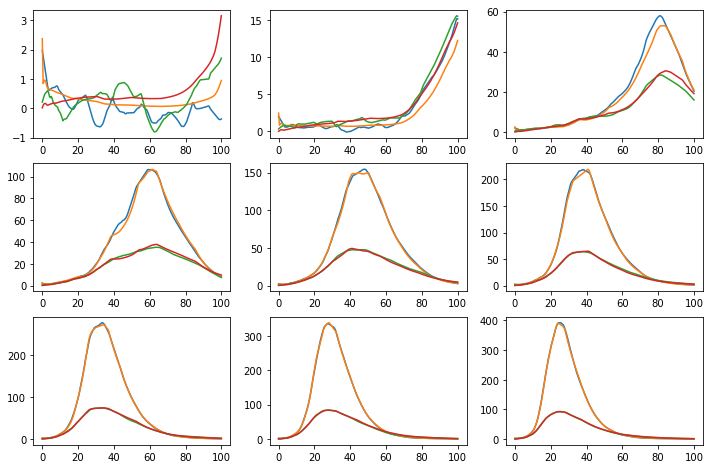

In [75]:
betas = np.linspace(0.,0.5,num=9)
plt.figure(figsize=(12,8));
for i,beta in enumerate(betas):
    plt.subplot(3,3,i+1);
    
    t_test = np.float32(np.linspace(0.,100,num=n))
    x_test = np.vstack((beta*np.ones(n),t_test)).T
    output = simple_model.predict(x_test)

    original_output = model.predict(x_test)
    mu,sigma = pydra.get_stats(original_output,distribution='Gamma')

    plt.plot(t_test,output[:,0],label='mean');
    plt.plot(t_test,mu,label='true mean');


    plt.plot(t_test,output[:,1],label='variance');
    plt.plot(t_test,sigma,label='true variance');

In [62]:
tfjs.converters.save_keras_model(simple_model, './SIR_model')